In [38]:
import pandas as pd 
import nltk
import re 
import sklearn
import matplotlib.pyplot as plt
from  nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/mikosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
def read_data(filename):
    """
    Reads data from a CSV file into a pandas DataFrame.

    Parameters:
    - filename (str): The name of the CSV file to read.

    Returns:
    - data (DataFrame): The DataFrame containing the data read from the CSV file.
    """
    data = pd.read_csv(filename)
    return data


In [25]:
# Calling the read_data function to read the 'AI_Human.csv' file into a DataFrame named 'data'
data = read_data('data/AI_Human.csv')


In [26]:
# Displaying the first few rows of the DataFrame to show the mapping between labels and categories:
# - 0.0 corresponds to 'Human'
# - 1.0 corresponds to 'AI'
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [29]:
# Splitting the data into training, validation, and testing sets using numpy's split function
# The data is shuffled using sample(frac=1) and a random_state of 50 is set for reproducibility
# The split points are calculated based on the lengths of the data:
# - 70% of the data is allocated for training
# - 25% of the data is allocated for validation
# - 5% of the data is allocated for testing
train, val, test = np.split(data.sample(frac=1, random_state=50),
                             [int(0.7*len(data)), int(0.95 * len(data))])


/Users/mikosa/nlp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [30]:
train.head()

,text,generated
51900,There are some undeniable advantages of not dr...,0.0
410588,Iitle: the Advantages of Limiting Car Usage: A...,1.0
370362,All around the world in places such as the Uni...,0.0
89364,Have you ever seen or ever been on Mars? Most ...,0.0
339228,Zoos are like super cool places where You can ...,1.0


In [61]:
# Extracting text and generated labels from the training set
x_train, y_train = train['text'].values, train['generated'].values

# Extracting text and generated labels from the validation set
x_val, y_val = val['text'].values, val['generated'].values

# Extracting text and generated labels from the testing set
x_test, y_test = test['text'].values, test['generated'].values


In [62]:
# Regular expression patterns for replacing bad words and symbols
REPLACE_BAD_WORD = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOL = re.compile('[^0-9a-z ]')

# Set of English stopwords for text preprocessing
STOPWORDS = set(stopwords.words('english'))

# WordNet lemmatizer for lemmatization
lemma = WordNetLemmatizer()

def text_preprocess(text):
    """
    Preprocesses the input text by converting to lowercase, removing bad words and symbols, 
    lemmatizing, and removing stopwords.

    Parameters:
    - text (str): The input text to be preprocessed.

    Returns:
    - processed_text (str): The preprocessed text.
    """
    text = text.lower()  # Convert text to lowercase
    text = REPLACE_BAD_WORD.sub(' ', text)  # Replace bad words with spaces
    text = BAD_SYMBOL.sub(' ', text)  # Remove symbols
    text = ' '.join(lemma.lemmatize(word) for word in text.split() if word not in STOPWORDS)  # Lemmatize and remove stopwords

    return text


In [63]:
# Preprocessing the text data in the training set using the text_preprocess function
x_train = [text_preprocess(x) for x in x_train]

# Preprocessing the text data in the validation set using the text_preprocess function
x_val = [text_preprocess(x) for x in x_val]

# Preprocessing the text data in the testing set using the text_preprocess function
x_test = [text_preprocess(x) for x in x_test]


In [66]:
# Dictionary to store word counts
words_count = {}

# Counting occurrences of each word in the training set
for text in x_train:
    for word in text.split():
        if word in words_count:
            words_count[word] += 1
        else:
            words_count[word] = 1

# Finding the top 3 most common words
top_words = sorted(words_count.items(), key=lambda x: x[1], reverse=True)[:3]

# Extracting the names of the top words
top_words_names = [word[0] for word in top_words]

# Creating a comma-separated string of the top words
word_output = ','.join(top_words_names)

# Printing the output
print(word_output)


student,car,people


In [82]:
def tfidf_features(x_train, x_val, x_test):
    """
    Extract TF-IDF features from the input text data.

    Parameters:
    - x_train (list): List of strings containing the training text data.
    - x_val (list): List of strings containing the validation text data.
    - x_test (list): List of strings containing the testing text data.

    Returns:
    - X_train (sparse matrix): TF-IDF features of the training text data.
    - X_val (sparse matrix): TF-IDF features of the validation text data.
    - X_test (sparse matrix): TF-IDF features of the testing text data.
    - vocabulary (dict): Vocabulary learned from the training data.
    """
    # Define parameters for TF-IDF vectorization
    max_df_value = 0.9  # Ignore terms that appear in more than 90% of documents
    min_df_value = 0.01  # Ignore terms that appear in less than 1% of documents

    # Initialize TF-IDF vectorizer with specified parameters
    tfidf_vector = TfidfVectorizer(min_df=min_df_value, max_df=max_df_value, ngram_range=(1, 2), token_pattern=r'\b\w+\b')

    # Fit the vectorizer on the training data and transform all sets
    tfidf_vector.fit(x_train)
    X_train = tfidf_vector.transform(x_train)
    X_val = tfidf_vector.transform(x_val)
    X_test = tfidf_vector.transform(x_test)

    # Get the vocabulary learned from the training data
    vocabulary = tfidf_vector.vocabulary_

    return X_train, X_val, X_test, vocabulary


In [83]:
# Extracting TF-IDF features from the text data using the tfidf_features function
x_train_tfidf, x_val_tfidf, x_test_tfidf, tfidf_vocab = tfidf_features(x_train, x_val, x_test) 

# Creating a reversed vocabulary dictionary for TF-IDF features
tfidf_reversed_vocab = {i: word for word, i in tfidf_vocab.items()}


In [91]:
tfidf_vocab['girl']

1137

In [86]:
y_train

array([0., 1., 0., ..., 0., 0., 0.])

In [92]:
from sklearn.linear_model import LogisticRegression, Ridge

def train_classifier(x_train, y_train):
    """
    Trains a logistic regression classifier using the input features and labels.

    Parameters:
    - x_train (sparse matrix): TF-IDF features of the training text data.
    - y_train (array-like): Array-like object containing the labels for the training data.

    Returns:
    - clf (LogisticRegression): Trained logistic regression classifier.
    """
    # Initialize and train a logistic regression classifier
    clf = LogisticRegression().fit(x_train, y_train)
    
    return clf

In [93]:
# Training a logistic regression classifier using the TF-IDF features of the training data
my_classifier = train_classifier(x_train_tfidf, y_train)


In [94]:
# Predicting labels for the validation set using the trained classifier
y_pred_val = my_classifier.predict(x_val_tfidf)

# Calculating decision function scores for the validation set using the trained classifier
y_val_predicted_scores_tfidf = my_classifier.decision_function(x_val_tfidf)


In [108]:
label_name = {'Human':0, 'AI':1}

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [96]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

def print_evaluation_scores(y_val, predicted):
    """
    Prints evaluation scores such as accuracy, F1 scores, and precision scores.

    Parameters:
    - y_val (array-like): Array-like object containing the true labels.
    - predicted (array-like): Array-like object containing the predicted labels.
    """
    # Calculate and print accuracy score
    print(f"Accuracy Score: {accuracy_score(y_val, predicted)}")

    # Calculate and print F1 score (macro, micro, weighted)
    print(f"F1 Score (Macro): {f1_score(y_val, predicted, average='macro')}")
    print(f"F1 Score (Micro): {f1_score(y_val, predicted, average='micro')}")
    print(f"F1 Score (Weighted): {f1_score(y_val, predicted, average='weighted')}")

    # Calculate and print precision score (macro, micro, weighted)
    print(f"Precision (Macro): {average_precision_score(y_val, predicted, average='macro')}")
    print(f"Precision (Micro): {average_precision_score(y_val, predicted, average='micro')}")
    print(f"Precision (Weighted): {average_precision_score(y_val, predicted, average='weighted')}")


In [97]:
print_evaluation_scores(y_val, y_pred_val)

Accuracy Score: 0.9916837015327274
F1 Score(Macro): 0.9910721625534494
F1 Score(Micro): 0.9916837015327274
F1 Score(Weighted): 0.9916773521160982
Precision(Macro): 0.9831280815926449
Precision(Micro): 0.9831280815926449
Precision(Weighted): 0.9831280815926449


In [98]:
print_evaluation_scores(y_train, my_classifier.predict(x_train_tfidf))

Accuracy Score: 0.9926318814064222
F1 Score(Macro): 0.9921104828323886
F1 Score(Micro): 0.9926318814064222
F1 Score(Weighted): 0.9926262142245309
Precision(Macro): 0.9853579572290236
Precision(Micro): 0.9853579572290236
Precision(Weighted): 0.9853579572290236


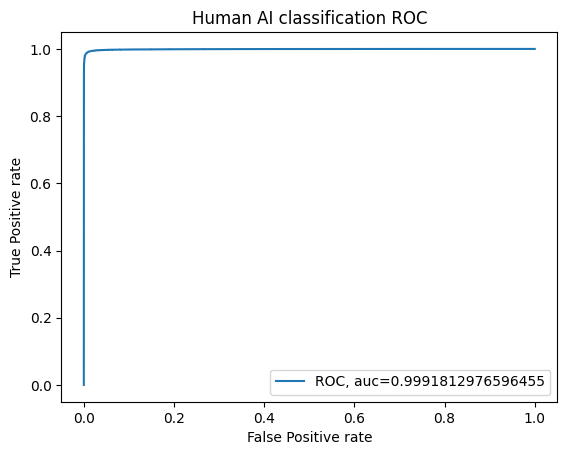

In [134]:
# Predicting probabilities for the positive class (AI) using the trained classifier
y_pred_proba = my_classifier.predict_proba(x_val_tfidf)[:, 1]

# Calculating the false positive rate (fpr) and true positive rate (tpr) for the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, y_pred_proba)

# Calculating the area under the ROC curve (AUC)
auc = sklearn.metrics.roc_auc_score(y_val, y_pred_proba)

# Plotting the ROC curve
plt.plot(fpr, tpr, label="ROC, auc=" + str(auc))
plt.title('Human AI classification ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
